In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
%cd /content/drive/MyDrive/FundamentalLearningEPFL/TP11

/content/drive/MyDrive/FundamentalLearningEPFL/TP11


# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [79]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [80]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

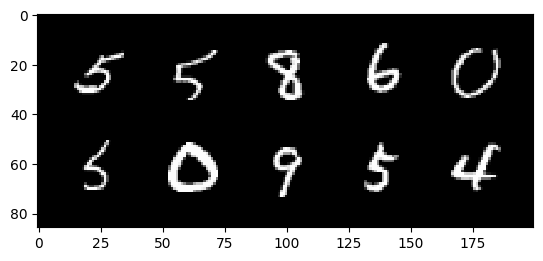

In [81]:
visualize_images(train_dataloader)

In [82]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [83]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.4559707651704044
Epoch 1: Loss=0.42159580755031717
Epoch 2: Loss=0.24430000933550172
Epoch 3: Loss=0.1918148659801079
Epoch 4: Loss=0.15918750214879795
Epoch 5: Loss=0.13938949358160213
Epoch 6: Loss=0.12392425335059731
Epoch 7: Loss=0.112235268293801
Epoch 8: Loss=0.104245536787025
Epoch 9: Loss=0.09682578542980097
Test set: Avg. loss: 0.0860, Accuracy: 9741/10000 (97%)


(0.08603177871704101, tensor(97.4100, device='cuda:0'))

## CIFAR10

In [84]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


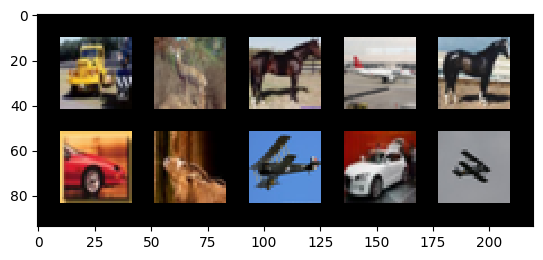

In [85]:
visualize_images(train_dataloader)

In [87]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

RuntimeError: ignored

The above failed! We have to make modifications to the model and perform the same training loop.

Modify the previous CNN code: [0.25 points]
- Hint 1: What difference can you notice with the MNIST images?
- Hint 2: How many pixels are the CIFAR10 images?

In [88]:
# YOUR CODE HERE

class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048,10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x

In [89]:
# initialize model
cnn = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.2344664262265574
Epoch 1: Loss=2.0988066391069062
Epoch 2: Loss=1.997699506428777
Epoch 3: Loss=1.859947803069134
Epoch 4: Loss=1.7355918470694094
Epoch 5: Loss=1.6982157327690903
Epoch 6: Loss=1.6229686080193033
Epoch 7: Loss=1.575325184938859
Epoch 8: Loss=1.5430277367027438
Epoch 9: Loss=1.5104199380290753
Test set: Avg. loss: 1.4528, Accuracy: 4862/10000 (49%)


(1.4528080200195312, tensor(48.6200, device='cuda:0'))

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [90]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [91]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Modify the fit function to also use a validation set

In [92]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

Epoch 0: Train Loss=1.4582, Validation Loss=0.7248, Validation acc=75.0200
Epoch 1: Train Loss=0.4305, Validation Loss=0.3194, Validation acc=90.9900
Epoch 2: Train Loss=0.2719, Validation Loss=0.2388, Validation acc=93.0500
Epoch 3: Train Loss=0.2124, Validation Loss=0.2007, Validation acc=94.2200
Epoch 4: Train Loss=0.1785, Validation Loss=0.1713, Validation acc=95.1600
Epoch 5: Train Loss=0.1558, Validation Loss=0.1558, Validation acc=95.6200
Epoch 6: Train Loss=0.1398, Validation Loss=0.1458, Validation acc=95.9000
Epoch 7: Train Loss=0.1261, Validation Loss=0.1299, Validation acc=96.3100
Epoch 8: Train Loss=0.1164, Validation Loss=0.1193, Validation acc=96.6600
Epoch 9: Train Loss=0.1082, Validation Loss=0.1119, Validation acc=96.8500
Test set: Avg. loss: 0.0941, Accuracy: 9716/10000 (97%)


Text(0, 0.5, 'Train loss')

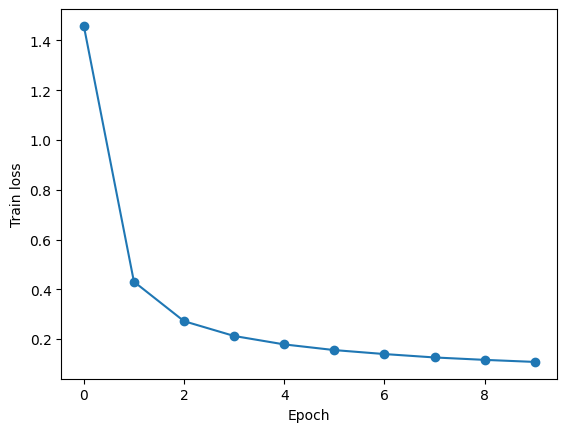

In [93]:
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

Epoch 0: Train Loss=2.3151, Validation Loss=2.3094, Validation acc=7.8300
Epoch 1: Train Loss=2.3032, Validation Loss=2.2977, Validation acc=10.7700
Epoch 2: Train Loss=2.2918, Validation Loss=2.2865, Validation acc=15.2500
Epoch 3: Train Loss=2.2807, Validation Loss=2.2753, Validation acc=18.3200
Epoch 4: Train Loss=2.2696, Validation Loss=2.2640, Validation acc=20.6400
Epoch 5: Train Loss=2.2581, Validation Loss=2.2523, Validation acc=22.9400
Epoch 6: Train Loss=2.2463, Validation Loss=2.2401, Validation acc=26.3000
Epoch 7: Train Loss=2.2337, Validation Loss=2.2272, Validation acc=32.0300
Epoch 8: Train Loss=2.2204, Validation Loss=2.2133, Validation acc=37.2500
Epoch 9: Train Loss=2.2059, Validation Loss=2.1982, Validation acc=42.0100
Test set: Avg. loss: 2.1960, Accuracy: 4396/10000 (44%)


Text(0, 0.5, 'Train loss')

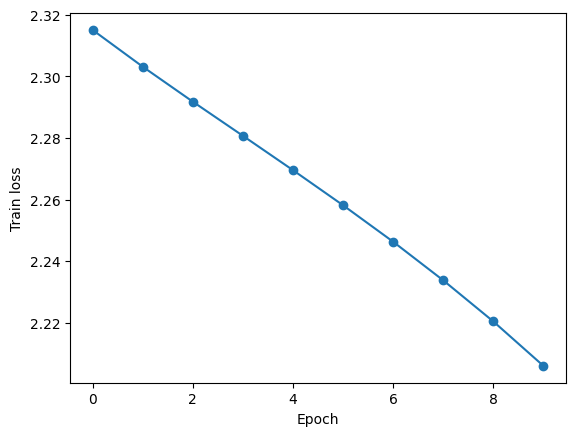

In [94]:
cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitative) what happens. [0.5 points]

Epoch 0: Train Loss=2.1704, Validation Loss=1.5316, Validation acc=54.8200
Epoch 1: Train Loss=2.2666, Validation Loss=2.3014, Validation acc=11.2900
Epoch 2: Train Loss=2.3016, Validation Loss=2.3009, Validation acc=11.2900
Epoch 3: Train Loss=2.3014, Validation Loss=2.3009, Validation acc=11.2900
Epoch 4: Train Loss=2.3015, Validation Loss=2.3009, Validation acc=11.2900
Epoch 5: Train Loss=2.3015, Validation Loss=2.3007, Validation acc=11.2900
Epoch 6: Train Loss=2.3015, Validation Loss=2.3008, Validation acc=11.2900
Epoch 7: Train Loss=2.3014, Validation Loss=2.3008, Validation acc=11.2900
Epoch 8: Train Loss=2.3015, Validation Loss=2.3008, Validation acc=11.2900
Epoch 9: Train Loss=2.3015, Validation Loss=2.3008, Validation acc=11.2900
Test set: Avg. loss: 2.3011, Accuracy: 1135/10000 (11%)


Text(0, 0.5, 'Train loss')

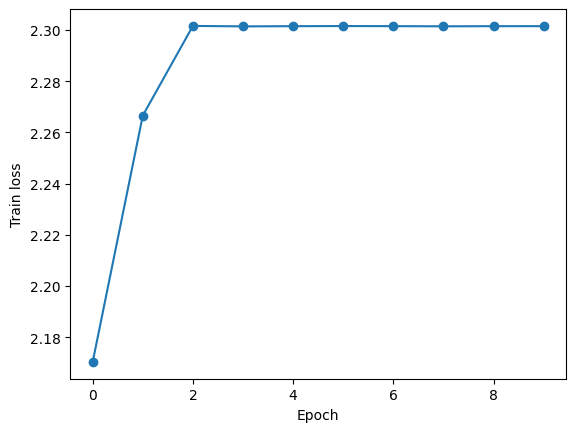

In [95]:
# YOUR CODE GOES HERE

cnn = CNN().to(DEVICE)

optimizer = torch.optim.SGD(cnn.parameters(), lr=0.7)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

As seen some weeks ago, if the learning rate is too high, the stochastic gradient "miss" the minimum by jumping from side to side. In a worst case, the gradient could diverge (if the learning rate is bigger).

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Implement momentum and compute the learning curve [0.25 points]

Epoch 0: Train Loss=2.2730, Validation Loss=2.2314, Validation acc=36.6700
Epoch 1: Train Loss=2.1739, Validation Loss=2.0929, Validation acc=63.0800
Epoch 2: Train Loss=1.9505, Validation Loss=1.7464, Validation acc=70.4000
Epoch 3: Train Loss=1.4506, Validation Loss=1.1307, Validation acc=75.8200
Epoch 4: Train Loss=0.9066, Validation Loss=0.7434, Validation acc=80.7600
Epoch 5: Train Loss=0.6498, Validation Loss=0.5896, Validation acc=83.5100
Epoch 6: Train Loss=0.5388, Validation Loss=0.5133, Validation acc=85.3400
Epoch 7: Train Loss=0.4780, Validation Loss=0.4672, Validation acc=86.5500
Epoch 8: Train Loss=0.4399, Validation Loss=0.4366, Validation acc=87.3200
Epoch 9: Train Loss=0.4119, Validation Loss=0.4112, Validation acc=88.0900
Test set: Avg. loss: 0.3869, Accuracy: 8882/10000 (89%)


Text(0, 0.5, 'Train loss')

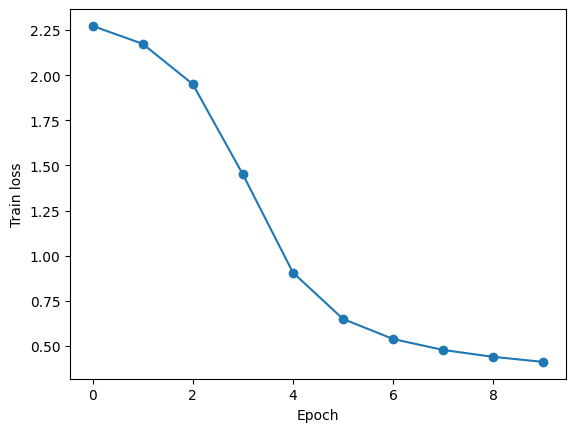

In [96]:
cnn = CNN().to(DEVICE)

# YOUR CODE GOES HERE
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

plt.plot(train_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Train loss")

## Hyperparameters: Learning rate and batch size [1 point]

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.

Model 1 : Learning rate: 0.01, Batch size: 256
Epoch 0: Train Loss=1.7514, Validation Loss=0.8399, Validation acc=79.1700
Epoch 1: Train Loss=0.5552, Validation Loss=0.5806, Validation acc=81.1600
Epoch 2: Train Loss=0.3989, Validation Loss=0.3981, Validation acc=87.2700
Epoch 3: Train Loss=0.3473, Validation Loss=0.3573, Validation acc=89.4400
Epoch 4: Train Loss=0.3148, Validation Loss=0.3180, Validation acc=90.7000
Epoch 5: Train Loss=0.2916, Validation Loss=0.3104, Validation acc=90.9000
Epoch 6: Train Loss=0.2715, Validation Loss=0.3081, Validation acc=90.4200
Epoch 7: Train Loss=0.2525, Validation Loss=0.2580, Validation acc=92.7600
Epoch 8: Train Loss=0.2371, Validation Loss=0.2496, Validation acc=93.0400
Epoch 9: Train Loss=0.2227, Validation Loss=0.2416, Validation acc=92.8300
Test set: Avg. loss: 0.2201, Accuracy: 9342/10000 (93%)
Model 2 : Learning rate: 0.01, Batch size: 512
Epoch 0: Train Loss=2.2454, Validation Loss=2.1653, Validation acc=51.4600
Epoch 1: Train Loss=1.930

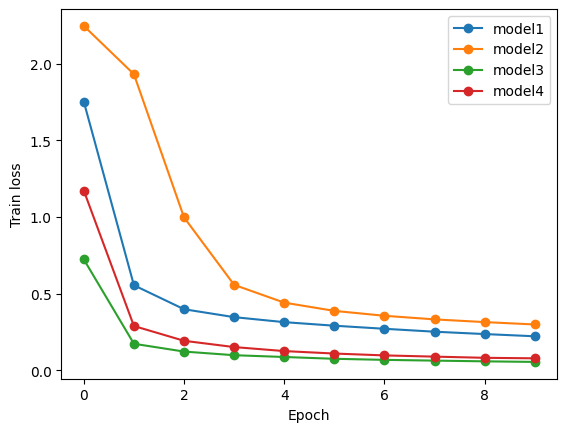

In [57]:
# Perform a grid search over 2 values of learning rate and 2 values of Batch size.

from itertools import product

LR_GRID = [0.01, 0.1]
BS_GRID = [256, 512]

# YOUR CODE GOES HERE
models = []
model_num = 1
for lr in LR_GRID:
    for bs in BS_GRID:
        print(f"Model {model_num} : Learning rate: {lr}, Batch size: {bs}")
        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=bs,
            shuffle=True,
            num_workers=2)

        valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)

        test_dataloader = DataLoader(
            dataset=test_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)

        cnn = CNN().to(DEVICE)

        optimizer = torch.optim.SGD(cnn.parameters(), lr=lr)

        train_losses, valid_losses, valid_accs = fit(
            model=cnn,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            optimizer=optimizer,
            epochs=10,
            device=DEVICE
        )
        models.append(cnn)

        predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

        plt.plot(train_losses, "-o",label ='model' + str(model_num))
        plt.xlabel("Epoch")
        plt.ylabel("Train loss")
        model_num += 1
plt.legend()
plt.show()

In [58]:
# Evaluate the performance on the test set with the best model!

predict(model=models[3], test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0698, Accuracy: 9778/10000 (98%)


(0.06981331958770752, tensor(97.7800, device='cuda:0'))

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [98]:
# first we load all the necessary libraries
import torchvision.transforms as transforms
import torch.nn.functional as F

In [99]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [100]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x=1$

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Redo the previous cnn architecture with batch normalization.
Where does the batch normalization go? [0.25 points]

In [101]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # reshape the tensor
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.6863
Epoch 1: Train Loss=1.2895
Epoch 2: Train Loss=1.1528
Epoch 3: Train Loss=1.0606
Epoch 4: Train Loss=1.0055
Epoch 5: Train Loss=0.9771
Epoch 6: Train Loss=0.9389
Epoch 7: Train Loss=0.9089
Epoch 8: Train Loss=0.8798
Epoch 9: Train Loss=0.8589
Epoch 10: Train Loss=0.8542
Epoch 11: Train Loss=0.8283
Epoch 12: Train Loss=0.8095
Epoch 13: Train Loss=0.7997
Epoch 14: Train Loss=0.7862
Epoch 15: Train Loss=0.7675
Epoch 16: Train Loss=0.7650
Epoch 17: Train Loss=0.7542
Epoch 18: Train Loss=0.7412
Epoch 19: Train Loss=0.7255
Test set: Avg. loss: 0.9813, Accuracy: 6741/10000 (67%)


(0.9813312072753906, tensor(67.4100, device='cuda:0'))

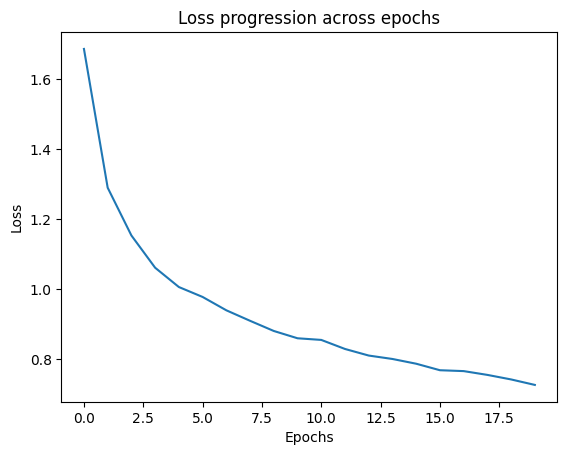

In [63]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 20,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster? [0.25 points]


yes it learns faster !

Epoch 0: Train Loss=1.6601
Epoch 1: Train Loss=1.2396
Epoch 2: Train Loss=1.1298
Epoch 3: Train Loss=1.0498
Epoch 4: Train Loss=0.9836
Epoch 5: Train Loss=0.9360
Epoch 6: Train Loss=0.8995
Epoch 7: Train Loss=0.8748
Epoch 8: Train Loss=0.8490
Epoch 9: Train Loss=0.8211
Epoch 10: Train Loss=0.8158
Epoch 11: Train Loss=0.7891
Epoch 12: Train Loss=0.7669
Epoch 13: Train Loss=0.7649
Epoch 14: Train Loss=0.7440
Epoch 15: Train Loss=0.7412
Epoch 16: Train Loss=0.7207
Epoch 17: Train Loss=0.7151
Epoch 18: Train Loss=0.7039
Epoch 19: Train Loss=0.6883
Test set: Avg. loss: 0.9659, Accuracy: 6774/10000 (68%)


(0.9659370422363281, tensor(67.7400, device='cuda:0'))

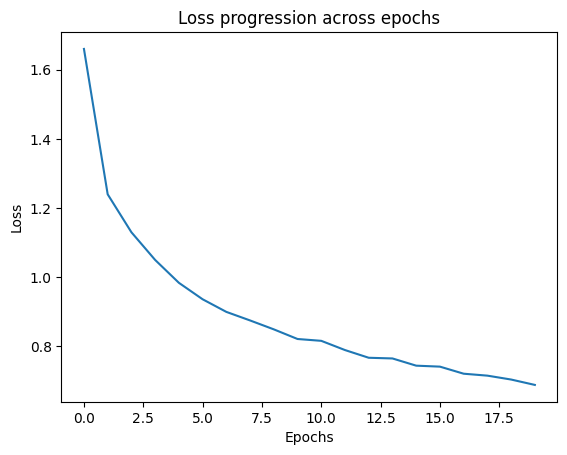

In [102]:
cnn3 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn3.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn3,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 20,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn3,
    test_dataloader = test_dataloader,
    device = DEVICE
)

## Learning rate scheduler [0.5 points]

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and me start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [65]:
def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    """
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    """

    # keep track of the losses in order to visualize them later
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step()

    return losses


Now train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

In [66]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,50], gamma=0.1)

losses = fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 50,
        device = DEVICE,
        scheduler=scheduler,
    )

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

Epoch 0: Loss=3.283103743377997
Epoch 1: Loss=2.2487391987625434
Epoch 2: Loss=2.0695961008266526
Epoch 3: Loss=1.9946939531637697
Epoch 4: Loss=1.9583613191332137
Epoch 5: Loss=1.9230128721315034
Epoch 6: Loss=1.878261617251805
Epoch 7: Loss=1.811370932326025
Epoch 8: Loss=1.71172161734834
Epoch 9: Loss=1.5930538469431352
Epoch 10: Loss=1.5261906774676577
Epoch 11: Loss=1.4645348495366621
Epoch 12: Loss=1.399995808698693
Epoch 13: Loss=1.3566818261633113
Epoch 14: Loss=1.3145055892516155
Epoch 15: Loss=1.2881024492030242
Epoch 16: Loss=1.2541567087173462
Epoch 17: Loss=1.245249096228152
Epoch 18: Loss=1.2326197624206543
Epoch 19: Loss=1.2134147712162562
Epoch 20: Loss=1.1697510748493427
Epoch 21: Loss=1.1588455438613892
Epoch 22: Loss=1.1550416435514177
Epoch 23: Loss=1.1531880583081926
Epoch 24: Loss=1.1524990383459597
Epoch 25: Loss=1.149873363728426
Epoch 26: Loss=1.1481597983107275
Epoch 27: Loss=1.14661464399221
Epoch 28: Loss=1.1458061738890044
Epoch 29: Loss=1.1435222309462878


(1.2118126708984376, tensor(57.4300, device='cuda:0'))

## Residual connections [1 point]

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [67]:
class WrongBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [68]:
from training_utils import fit

Epoch 0: Loss=2.1826222916038667
Epoch 1: Loss=1.8217801804445228
Epoch 2: Loss=1.6431269134793962
Test set: Avg. loss: 2.8204, Accuracy: 2483/10000 (25%)


(2.8203919921875, tensor(24.8300, device='cuda:0'))

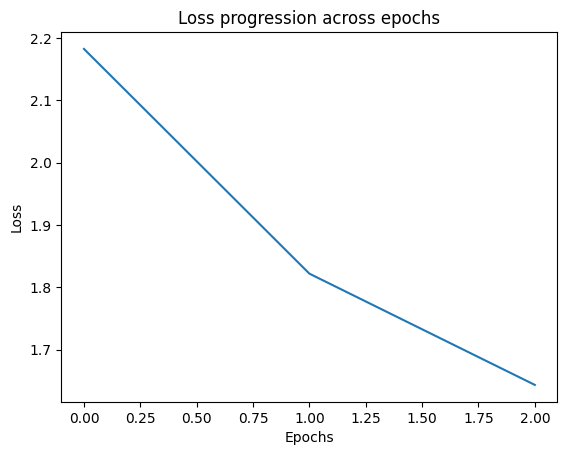

In [69]:
# initialize the model
model = ResNet(block=WrongBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
  fit(
          model,
          train_dataloader = train_dataloader,
          optimizer = optimizer,
          epochs = 3,
          device = DEVICE
      )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


#Your answer here#

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

Fill the code below!

In [70]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().init()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

Epoch 0: Loss=2.2471001026581745
Epoch 1: Loss=1.894254399805653
Epoch 2: Loss=1.7049229801917563
Epoch 3: Loss=1.5212601812518374
Epoch 4: Loss=1.3678442604687748
Epoch 5: Loss=1.2356185450845836
Epoch 6: Loss=1.1407034956679052
Epoch 7: Loss=1.0348779899733407
Epoch 8: Loss=0.9547402542464587
Epoch 9: Loss=0.8934896089592759
Test set: Avg. loss: 0.9661, Accuracy: 6542/10000 (65%)


(0.9660506286621093, tensor(65.4200, device='cuda:0'))

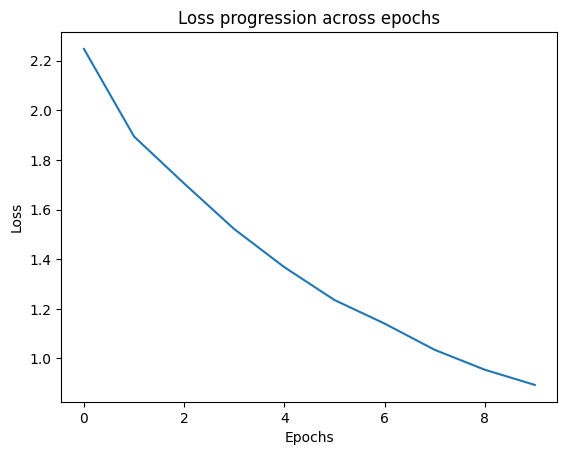

In [71]:
# initialize the model
from training_utils import fit
model = ResNet(block=WrongBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 10,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)
